
# Przygotowanie środowiska

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np

In [249]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Layer, ReLU, UpSampling2D, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, RMSprop, Adam
from tensorflow.python.keras import backend as K
from tensorflow.keras import layers, regularizers
from tensorflow.keras.datasets import cifar100

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from cv2 import resize
from os import path, listdir, remove

from PIL import Image
from skimage import io, color
import matplotlib.pyplot as plt

# Oczyszczenie zbioru danych

Oczyszczenie zbioru obrazów (usunięcie obrazów będących w skali szarości)

In [ ]:
directory = '/content/drive/My Drive/imagenette2/train'
image_paths = []
for class_label, class_dir in enumerate(listdir(directory)):
  image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]

for img_path in image_paths:
  img = io.imread(img_path)
  img = np.array(img)
  if len(img.shape) == 2:
    print(img_path)
    remove(img_path)

In [ ]:
directory = '/content/drive/My Drive/imagenette2/val'
image_paths = []
for class_label, class_dir in enumerate(listdir(directory)):
  image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]

for img_path in image_paths:
  img = io.imread(img_path)
  img = np.array(img)
  if len(img.shape) == 2:
    print(img_path)
    remove(img_path)

Zredukowanie rozmiaru zbioru walidacyjnego

In [ ]:
directory = '/content/drive/My Drive/imagenette2/val'
image_paths = []
for class_label, class_dir in enumerate(listdir(directory)):
  image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]

for i in range(len(image_paths) - 100):
  remove(image_paths[i])

In [ ]:
image_paths = []
for class_label, class_dir in enumerate(listdir(directory)):
  image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]
print(len(image_paths))

100


# Architektura autoenkodera

In [587]:
class Encoder(Model):

  def __init__(self, use_batch_normalization, dropout_rate, l2_penalty, momentum):
    super(Encoder, self).__init__()

    self.use_batch_normalization = use_batch_normalization

    self.conv_1 = Conv2D(1, 3, activation='relu', padding='same')
    self.conv_2 = Conv2D(32, 3, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))
    self.conv_3 = Conv2D(64, 3, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))
    self.conv_4 = Conv2D(128, 3, strides=(2, 2), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))

    self.batch_normalization = BatchNormalization()
    self.dropout = Dropout(dropout_rate)

  def call(self, inputs):
    x = inputs

    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.dropout(x)
    x = self.conv_3(x)
    x = self.dropout(x)
    x = self.conv_4(x)

    if self.use_batch_normalization:
      x = self.batch_normalization(x)


    return x

class Decoder(Model):

  def __init__(self, use_batch_normalization, dropout_rate, l2_penalty, momentum):
    super(Decoder, self).__init__()

    self.use_batch_normalization = use_batch_normalization

    self.conv_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))
    self.upsampling_1 = UpSampling2D((2, 2))

    self.conv_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))
    self.upsampling_2 = UpSampling2D((2, 2))

    self.conv_3 = Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))
    self.upsampling_3 = UpSampling2D((2, 2))

    self.conv_4 = Conv2D(2, 3, activation='tanh', padding='same', kernel_regularizer=regularizers.l2(l2_penalty))

    self.batch_normalization = BatchNormalization()
    self.dropout = Dropout(dropout_rate)
    
  def call(self, inputs):
    x = inputs

    x = self.conv_1(x)
    x = self.upsampling_1(x)
    x = self.conv_2(x)
    x = self.upsampling_2(x)
    x = self.dropout(x)
    x = self.conv_3(x)
    x = self.upsampling_3(x)

    if self.use_batch_normalization:
      x = self.batch_normalization(x)

    x = self.conv_4(x)

    return x

class Autoencoder(Model):

  def __init__(self, use_batch_normalization=False, dropout_rate=0, l2_penalty=0, momentum=0.99):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder(use_batch_normalization, dropout_rate, l2_penalty, momentum)
    self.decoder = Decoder(use_batch_normalization, dropout_rate, l2_penalty, momentum)
    
  def call(self, inputs):
    x = self.encoder(inputs)
    x = self.decoder(x)

    return x

# Data generator

In [567]:
class ImageGenerator():

    def __init__(self, directory, batch_size=16, shuffle=False, max_dimension=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_dimension = max_dimension
        
        self.image_paths = []
        
        #create list of image file paths and class target labels
        for class_label, class_dir in enumerate(listdir(directory)):
            self.image_paths += [path.join(directory,class_dir,f) for f in listdir(path.join(directory,class_dir))]

        self.image_paths = np.array(self.image_paths[:200])

        self.idx = np.arange(len(self.image_paths))
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self,img_path):
        
        #load image from path and convert to array
        img = io.imread(img_path)
        img = np.array(img)
        
        #downsample image if above allowed size if specified
        max_dim = max(img.shape) 
        if self.max_dimension:
            if max_dim > self.max_dimension:
                new_dim = tuple(d*self.max_dimension//max_dim for d in img.shape[1::-1])
                img = resize(img, new_dim)
            
        return img

    def match_shape_with_pooling(self, shape, n=8):
      a = 0
      b = 0
      while a < shape[0]:
        a += n
      while b < shape[1]:
        b += n
      return (a, b)
    
    def _pad_images(self,img,shape):
        #pad images to match largest image in batch
        shape = self.match_shape_with_pooling(shape)
        img = np.pad(img,(*[((shape[i]-img.shape[i])//2,
                    ((shape[i]-img.shape[i])//2) + ((shape[i]-img.shape[i])%2)) for i in range(2)],
                          (0,0)),mode='constant',constant_values=0.)
        
        return img


    def lab_img(self, img):
      img_lab = color.rgb2lab(img)
      img_lab = img_lab.astype('float32')
      l_layer = img_lab[:, :, :1] / 100
      ab_layers = img_lab[:, :, 1:] / 128

      return l_layer, ab_layers


    def __call__(self):
        #shuffle index
        if self.shuffle:
            np.random.shuffle(self.idx)

        #generate batches
        for batch in range(len(self)):

            batch_image_paths = self.image_paths[self.idx[batch*self.batch_size:(batch+1)*self.batch_size]]
            batch_images = [self._load_image(image_path) for image_path in batch_image_paths]



            max_resolution = tuple(max([img.shape[i] for img in batch_images]) for i in range(2))

            batch_images = np.array([self._pad_images(image,max_resolution) for image in batch_images])
            batch_output = np.array([self._pad_images(image,max_resolution) for image in batch_images])

            batch_images = [self.lab_img(img)[0] for img in batch_images]
            batch_output = [self.lab_img(img)[1] for img in batch_output]

            yield batch_images, batch_output

In [518]:
#initialize our generators; specifying data directories, batch size, and dimension threshold

train_image_directory = '/content/drive/My Drive/imagenette2/train'
test_image_directory = '/content/drive/My Drive/imagenette2/val'

batch_size = 4
max_dimension = 128

#create generators for training and generating

train_generator = ImageGenerator(train_image_directory, batch_size=batch_size, shuffle=True, max_dimension=max_dimension)
test_generator = ImageGenerator(test_image_directory, batch_size=batch_size, max_dimension=max_dimension)

#convert generators into tf.data.Dataset objects for optimization with keras model fit method

train_dataset = tf.data.Dataset.from_generator(train_generator,
    (tf.float32, tf.float32),
    (tf.TensorShape([None,None,None,1]), tf.TensorShape([None,None,None,2])))

test_dataset = tf.data.Dataset.from_generator(test_generator,
    (tf.float32, tf.float32),
    (tf.TensorShape([None,None,None,1]), tf.TensorShape([None,None,None,2])))

# Zbadanie wpływu regularyzacji na wynik

Model bez regularyzacji


In [568]:
autoencoder = Autoencoder(use_batch_normalization=False, dropout_rate=0, l2_penalty=0)
autoencoder.compile(optimizer= Adam(learning_rate=0.001),
              loss='mean_squared_error')

history_no_regularization = autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=50)

Epoch 1/50
25/25 [==============================] - 4s 156ms/step - loss: 0.0122 - val_loss: 0.0157
Epoch 2/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 3/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0120 - val_loss: 0.0151
Epoch 4/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0093 - val_loss: 0.0151
Epoch 5/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0115 - val_loss: 0.0152
Epoch 6/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0126 - val_loss: 0.0150
Epoch 7/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0109 - val_loss: 0.0150
Epoch 8/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0112 - val_loss: 0.0144
Epoch 9/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0113 - val_loss: 0.0145
Epoch 10/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0102 - val_loss: 0.0151

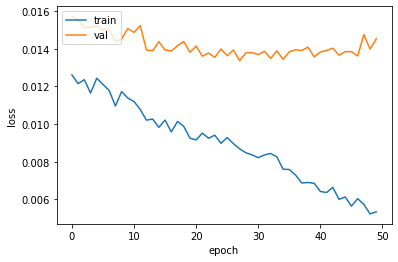

In [569]:
plt.plot(history_no_regularization.history['loss'])
plt.plot(history_no_regularization.history['val_loss'])
plt.title('')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Badanie wpływu Dropout Rate

In [588]:
dropout_rates = [0.2, 0.5, 0.7]
history_dropout_rates = []

for dropout_rate in dropout_rates:
  autoencoder = Autoencoder(use_batch_normalization=False, dropout_rate=dropout_rate, l2_penalty=0)
  autoencoder.compile(optimizer= Adam(learning_rate=0.001),
                loss='mean_squared_error')

  history = autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=50)
  history_dropout_rates.append(history)

Epoch 1/50
25/25 [==============================] - 4s 146ms/step - loss: 0.0112 - val_loss: 0.0158
Epoch 2/50
25/25 [==============================] - 3s 142ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 3/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0131 - val_loss: 0.0153
Epoch 4/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0110 - val_loss: 0.0148
Epoch 5/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0116 - val_loss: 0.0159
Epoch 6/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0129 - val_loss: 0.0158
Epoch 7/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0131 - val_loss: 0.0158
Epoch 8/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0132 - val_loss: 0.0158
Epoch 9/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0122 - val_loss: 0.0158
Epoch 10/50
25/25 [==============================] - 3s 142ms/step - loss: 0.0135 - val_loss: 0.0157

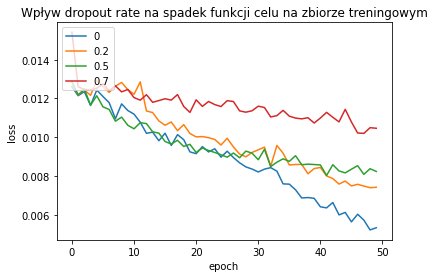

In [610]:
plt.plot(history_no_regularization.history['loss'])
for history in history_dropout_rates:
  plt.plot(history.history['loss'])
  

plt.legend([0, 0.2, 0.5, 0.7], loc='upper left')
plt.title('Wpływ dropout rate na spadek funkcji celu na zbiorze treningowym')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

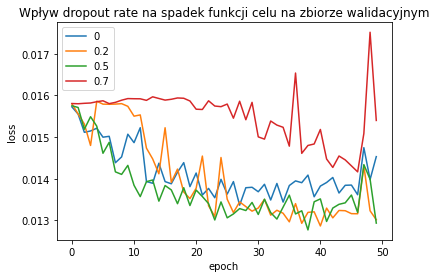

In [614]:
plt.plot(history_no_regularization.history['val_loss'])
for history in history_dropout_rates:
  plt.plot(history.history['val_loss'])
  

plt.legend([0, 0.2, 0.5, 0.7], loc='upper left')
plt.title('Wpływ dropout rate na spadek funkcji celu na zbiorze walidacyjnym')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Badanie wpływu współczynnika momentum w Batch Normalization

In [613]:
momentums = [0.9, 0.95, 0.99]
history_batch_normalization = []

for momentum in momentums:
  autoencoder = Autoencoder(use_batch_normalization=True, dropout_rate=0, l2_penalty=0, momentum=momentum)
  autoencoder.compile(optimizer= Adam(learning_rate=0.001),
                loss='mean_squared_error')

  history = autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=50)
  history_batch_normalization.append(history)

Epoch 1/50
25/25 [==============================] - 4s 151ms/step - loss: 0.0186 - val_loss: 0.0159
Epoch 2/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0131 - val_loss: 0.0158
Epoch 3/50
25/25 [==============================] - 4s 145ms/step - loss: 0.0114 - val_loss: 0.0158
Epoch 4/50
25/25 [==============================] - 4s 143ms/step - loss: 0.0117 - val_loss: 0.0158
Epoch 5/50
25/25 [==============================] - 3s 142ms/step - loss: 0.0132 - val_loss: 0.0158
Epoch 6/50
25/25 [==============================] - 3s 142ms/step - loss: 0.0140 - val_loss: 0.0158
Epoch 7/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0117 - val_loss: 0.0158
Epoch 8/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0113 - val_loss: 0.0158
Epoch 9/50
25/25 [==============================] - 3s 141ms/step - loss: 0.0121 - val_loss: 0.0158
Epoch 10/50
25/25 [==============================] - 3s 142ms/step - loss: 0.0109 - val_loss: 0.0158

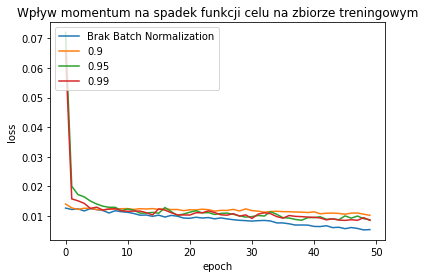

In [615]:
plt.plot(history_no_regularization.history['loss'])
for history in history_batch_normalization:
  plt.plot(history.history['loss'])
plt.legend(['Brak Batch Normalization', 0.9, 0.95, 0.99], loc='upper left')
plt.title('Wpływ momentum na spadek funkcji celu na zbiorze treningowym')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

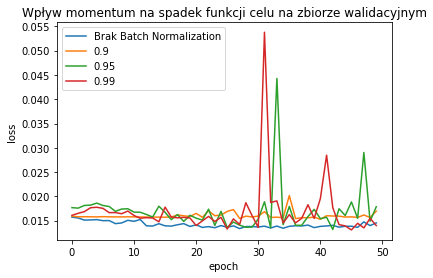

In [618]:
plt.plot(history_no_regularization.history['val_loss'])
for history in history_batch_normalization:
  plt.plot(history.history['val_loss'])
plt.legend(['Brak Batch Normalization', 0.9, 0.95, 0.99], loc='upper left')
plt.title('Wpływ momentum na spadek funkcji celu na zbiorze walidacyjnym')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Badanie wpływu współczynnika w regularyzacji L2

In [617]:
l2_rates = [1e-5, 1e-4, 1e-3]
history_weight_decay = []

for l2_rate in l2_rates:
  autoencoder = Autoencoder(use_batch_normalization=False, dropout_rate=0, l2_penalty=l2_rate)
  autoencoder.compile(optimizer= Adam(learning_rate=0.001),
                loss='mean_squared_error')

  history = autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=50)
  history_weight_decay.append(history)

Epoch 1/50
25/25 [==============================] - 4s 145ms/step - loss: 0.0149 - val_loss: 0.0184
Epoch 2/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0145 - val_loss: 0.0174
Epoch 3/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0138 - val_loss: 0.0167
Epoch 4/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0141 - val_loss: 0.0164
Epoch 5/50
25/25 [==============================] - 3s 139ms/step - loss: 0.0137 - val_loss: 0.0165
Epoch 6/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0122 - val_loss: 0.0162
Epoch 7/50
25/25 [==============================] - 3s 140ms/step - loss: 0.0122 - val_loss: 0.0161
Epoch 8/50
25/25 [==============================] - 3s 138ms/step - loss: 0.0121 - val_loss: 0.0161
Epoch 9/50
25/25 [==============================] - 3s 138ms/step - loss: 0.0117 - val_loss: 0.0160
Epoch 10/50
25/25 [==============================] - 3s 138ms/step - loss: 0.0114 - val_loss: 0.0160

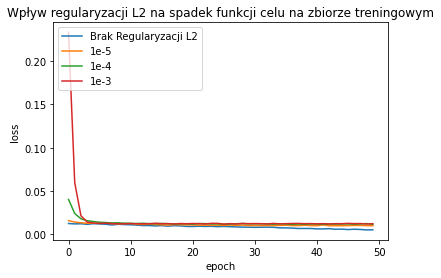

In [619]:
plt.plot(history_no_regularization.history['loss'])
for history in history_weight_decay:
  plt.plot(history.history['loss'])
plt.legend(['Brak Regularyzacji L2', '1e-5', '1e-4', '1e-3'], loc='upper left')
plt.title('Wpływ regularyzacji L2 na spadek funkcji celu na zbiorze treningowym')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

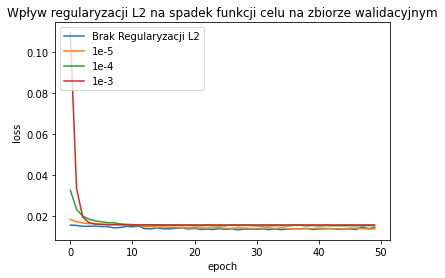

In [620]:
plt.plot(history_no_regularization.history['val_loss'])
for history in history_weight_decay:
  plt.plot(history.history['val_loss'])
plt.legend(['Brak Regularyzacji L2', '1e-5', '1e-4', '1e-3'], loc='upper left')
plt.title('Wpływ regularyzacji L2 na spadek funkcji celu na zbiorze walidacyjnym')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Finalny model

In [624]:
autoencoder = Autoencoder(use_batch_normalization=False, dropout_rate=0.5, l2_penalty=0)
autoencoder.compile(optimizer= Adam(learning_rate=0.001),
              loss='mean_squared_error')
autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=40)

Epoch 1/40
25/25 [==============================] - 4s 152ms/step - loss: 0.0171 - val_loss: 0.0159
Epoch 2/40
25/25 [==============================] - 4s 145ms/step - loss: 0.0133 - val_loss: 0.0158
Epoch 3/40
25/25 [==============================] - 4s 148ms/step - loss: 0.0126 - val_loss: 0.0158
Epoch 4/40
25/25 [==============================] - 4s 145ms/step - loss: 0.0145 - val_loss: 0.0158
Epoch 5/40
25/25 [==============================] - 4s 144ms/step - loss: 0.0120 - val_loss: 0.0158
Epoch 6/40
25/25 [==============================] - 4s 145ms/step - loss: 0.0129 - val_loss: 0.0160
Epoch 7/40
25/25 [==============================] - 4s 155ms/step - loss: 0.0125 - val_loss: 0.0154
Epoch 8/40
25/25 [==============================] - 4s 143ms/step - loss: 0.0126 - val_loss: 0.0153
Epoch 9/40
25/25 [==============================] - 4s 145ms/step - loss: 0.0118 - val_loss: 0.0153
Epoch 10/40
25/25 [==============================] - 4s 145ms/step - loss: 0.0111 - val_loss: 0.0153

# Wyniki

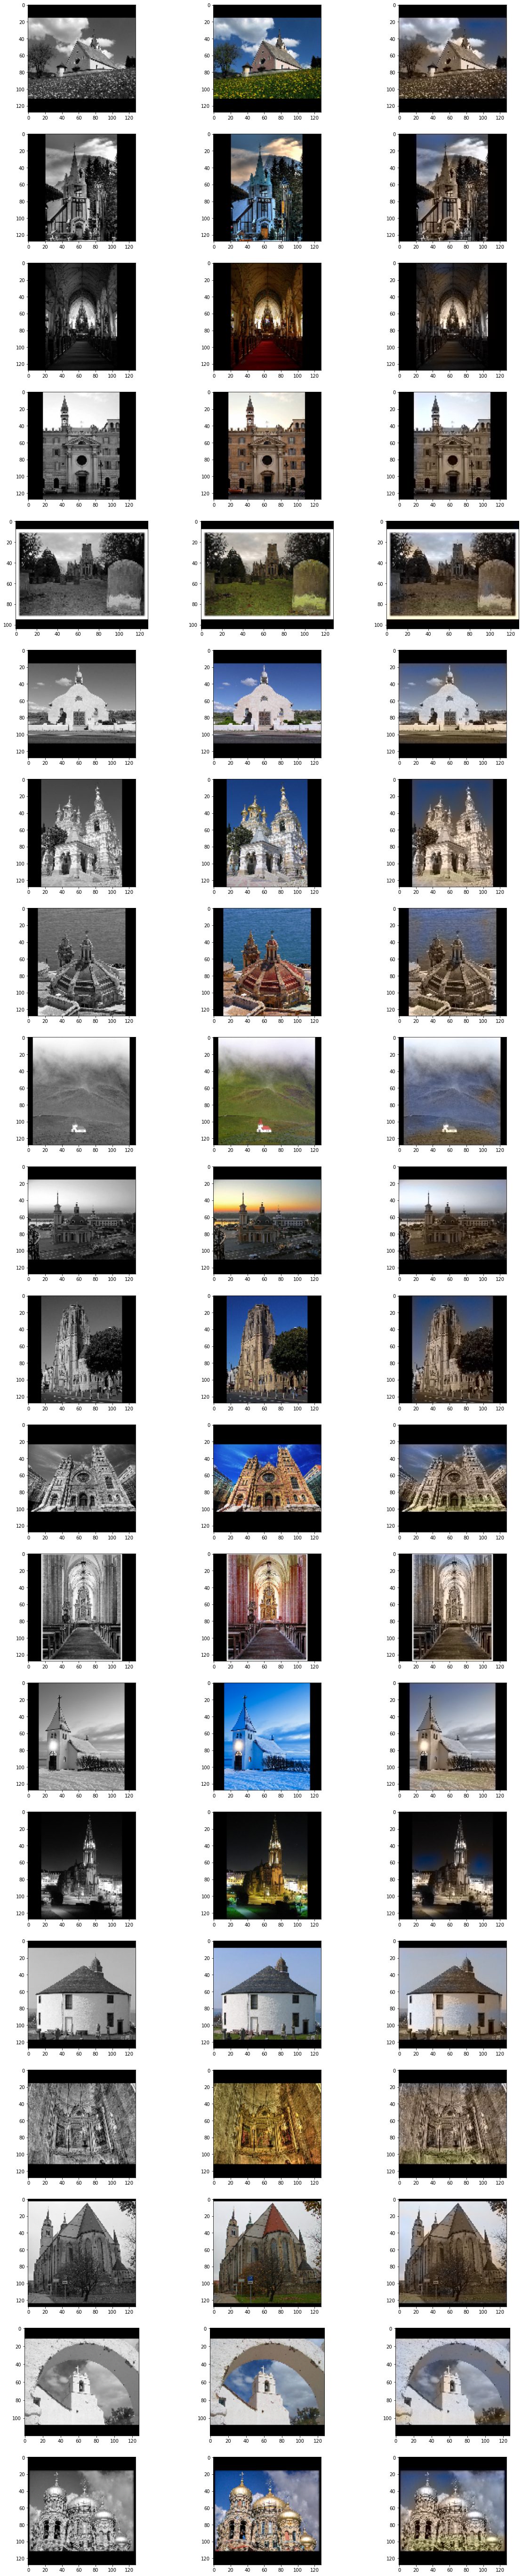

In [735]:
fig, axs = plt.subplots(20, 3, figsize=(20,100))
i = 0
for a1, b1 in test_dataset:
  predicted = autoencoder.predict(a1[:1, :, :, :])
  a1 = a1.numpy() * 100
  b1 = b1.numpy() * 128
  predicted = predicted * 128

  result = Concatenate(axis=3)([a1[:1, :, :, :], predicted[:1, :, :, :]])
  result = result.numpy()
  result = color.lab2rgb(result[0]) * 255
  result = Image.fromarray(np.uint8(result)).convert('RGB')

  original = Concatenate(axis=3)([a1[:1, :, :, :], b1[:1, :, :, :]])
  original = original.numpy()
  original = color.lab2rgb(original[0]) * 255
  original = Image.fromarray(np.uint8(original)).convert('RGB')

  dim1 = a1.shape[1]
  dim2 = a1.shape[2]

  axs[i][0].imshow(a1[:1, :, :, :].reshape([dim1, dim2]), cmap='gray')
  axs[i][1].imshow(original)
  axs[i][2].imshow(result)

  i += 1
  if i == 20:
    break


# **Podsumowanie rozwiązania**

# Przyjęte podejście do kolorowania obrazów

> Zamiast modelu RGB, zastosowano model kolorów LAB, gdzie L odpowiada za jasność (w głównym stopniu postrzeganą przez czowieka), A za spektrum kolorów zielonego oraz czerwonego a B za spektrum koloru niebieskiego i żółtego. Dzięki temu wynikowy obraz wierniej odzwierciedla sam kontent i ponadto liczba warst wynikowych, potrzebnych do pokolorowania obrazów zostałą zredukowana z 3 do 2.

> Wartości warstw A oraz B zostały znormalizowane do skali [-1, 1], dlatego na wyjściu enkodera zastosowano funkcję aktywacji tanh, o takim samym przedziale wartości.


# Przetwarzanie obrazów o róznym rozmiarze

>Aby zapewnić sieci możliwość przetwarzania obrazów o różnym rozmiarze zastosowana została architektura w pełni konwolucyjna, gdyż w przeciwieństwie do, na przykład, sieci neuronowych, nie wymaga ona aby dane wejściowe miały stały rozmiar. Sieć konwolucyjna zwraca wynik odpowiadający danym wejściowym, stosowny do zdefiniowanego kernela.

> W trakcie nauki autoenkodera jednak, konieczne jest aby rozmiary obrazów w obrębie jednego batcha były takie same, dlatego za pomocą klasy ImageGenerator tworzącej dataset dla funkcji uczącej, obrazom należącym do tego samego batcha dodawany jest padding aby wszystkie były w takim samym rozmiarze jak największy obraz. Ponadto autoenkoder najpierw ośmiokrotnie zmniejsza rozmiar przetwarzanego obrazu a następnie ośmiokrotnie go zwiększa do oryginalnego rozmiaru. Z tego powodu rozmiar obrazów musi być wielokrotnością liczby 8, dlatego aby to zapewnić dodatkowo dodawany jest kolejny padding. (Przeciwdziała to sytuacji, w której rozmiar wygenerowanego obrazu jest niekompatybilny z rozmiarem obrazu docelowego).

> Ponadto, jedynie na potrzebty tego zadania obrazy zostały przeskalowane tak aby nie przekraczały 128 pikseli, dzięki czemu proces uczenia jak i testowania wpływu regularyzacji znacząco został przyspieczony.

# Wpływ regularyzacji na wynik

> Jak obrazują to wygenerowane wykresy, zastosowanie regularyzacji L2 oraz batch normalization, nie wpłynęło pozytywnie na wartość funkcji celu dla zbioru walidacyjnego. Jedynie zastosowanie dropout'u porpawiło działanie autoenkodera, dlatego został on wykorzystany w finalnym modelu.









